In [2]:
import pandas as pd
import os
from collections import defaultdict

density_list = ['고밀도', '중밀도', '저밀도']
speed_list = ['고속', '중속', '저속']

node_dict = {
    '고밀도': {'고속': [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
              '중속': [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
              '저속': [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]},
    '중밀도': {'고속': [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
              '중속': [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
              '저속': [6, 7, 17, 18, 21, 22, 24, 26, 27, 29]},
    '저밀도': {'고속': [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
              '중속': [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
              '저속': [6, 7, 17, 18, 19, 21, 22, 24, 25, 26]}
}

failed_node_counts = {'기존': defaultdict(lambda: defaultdict(int)), '제안': defaultdict(lambda: defaultdict(int))}
collision_node_counts = {'기존': defaultdict(lambda: defaultdict(int)), '제안': defaultdict(lambda: defaultdict(int))}
rerr_node_counts = {'기존': defaultdict(int), '제안': defaultdict(int)}

transmit_counts = defaultdict(int)

base_dir = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/"

for density in density_list:
    for speed in speed_list:
        for mode in ['기존', '제안']:
            nodes = node_dict[density][speed]
            for node_id in nodes:
                node_path = os.path.join(base_dir, density, speed, mode, str(node_id))

                transmit_file = os.path.join(node_path, "transmitCount.txt")
                failed_file = os.path.join(node_path, "failedCount.txt")
                collision_file = os.path.join(node_path, "collision_log.txt")
                rerr_file = os.path.join(node_path, "rerr.txt")

                if not all(os.path.exists(f) for f in [transmit_file, failed_file, collision_file, rerr_file]):
                    print(f"파일 없음: {transmit_file}, {failed_file}, {collision_file}, 또는 {rerr_file}")
                    continue

                with open(transmit_file, 'r', encoding='utf-8') as f:
                    transmit_count = sum(1 for _, _ in zip(f, range(100000)))
                    transmit_counts[(mode, density, speed, node_id)] = transmit_count

                with open(failed_file, 'r', encoding='utf-8') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        if "node[" in line or "rsu[" in line:
                            failed_node = line.split(":")[0].strip()
                            failed_node_counts[mode][(density, speed, node_id)][failed_node] += 1

                with open(collision_file, 'r', encoding='utf-8') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        if "node[" in line or "rsu[" in line:
                            collided_node = line.split(":")[0].strip()
                            collision_node_counts[mode][(density, speed, node_id)][collided_node] += 1

                with open(rerr_file, 'r', encoding='utf-8') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        rerr_node_counts[mode][(density, speed, node_id)] += 1

failed_summary = []
for mode in ['기존', '제안']:
    for (density, speed, node_id), node_failures in failed_node_counts[mode].items():
        key = (mode, density, speed, node_id)
        transmit_count = transmit_counts.get(key, 0)
        for failed_node, count in node_failures.items():
            failure_rate = (count / transmit_count) * 100 if transmit_count > 0 else 0
            failed_summary.append([
                mode, density, speed, node_id,
                failed_node, count, transmit_count, failure_rate
            ])

df_failed_detail = pd.DataFrame(
    failed_summary,
    columns=['Mode', 'Density', 'Speed', 'Node_ID', 'Failed_Node', 'Failure_Count', 'Transmit_Count', 'Failure_Rate']
)
df_failed_detail.to_csv("failed_node_detail.csv", index=False, encoding="utf-8-sig")
print("노드별 실패 세부 CSV 저장 완료: failed_node_detail.csv")

collision_summary = []
for mode in ['기존', '제안']:
    for (density, speed, node_id), node_collisions in collision_node_counts[mode].items():
        key = (mode, density, speed, node_id)
        transmit_count = transmit_counts.get(key, 0)
        for collided_node, count in node_collisions.items():
            collision_rate = (count / transmit_count) * 100 if transmit_count > 0 else 0
            collision_summary.append([
                mode, density, speed, node_id,
                collided_node, count, transmit_count, collision_rate
            ])

df_collision_detail = pd.DataFrame(
    collision_summary,
    columns=['Mode', 'Density', 'Speed', 'Node_ID', 'Collided_Node', 'Collision_Count', 'Transmit_Count', 'Collision_Rate']
)
df_collision_detail.to_csv("collision_detail.csv", index=False, encoding="utf-8-sig")
print("노드별 충돌 세부 CSV 저장 완료: collision_detail.csv")

rerr_summary = []
for mode in ['기존', '제안']:
    for (density, speed, node_id), rerr_count in rerr_node_counts[mode].items():
        transmit_count = transmit_counts.get((mode, density, speed, node_id), 0)
        rerr_rate = (rerr_count / transmit_count) * 100 if transmit_count > 0 else 0
        rerr_summary.append([
            mode, density, speed, node_id,
            rerr_count, transmit_count, rerr_rate
        ])

df_rerr_detail = pd.DataFrame(
    rerr_summary,
    columns=['Mode', 'Density', 'Speed', 'Node_ID', 'RERR_Count', 'Transmit_Count', 'RERR_Rate']
)
df_rerr_detail.to_csv("rerr_detail.csv", index=False, encoding="utf-8-sig")
print("노드별 RERR 세부 CSV 저장 완료: rerr_detail.csv")


파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\기존\7\transmitCount.txt, C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\기존\7\failedCount.txt, C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\기존\7\collision_log.txt, 또는 C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\기존\7\rerr.txt
파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\제안\7\transmitCount.txt, C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\제안\7\failedCount.txt, C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\제안\7\collision_log.txt, 또는 C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/중밀도\저속\제안\7\rerr.txt
파일 없음: C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/저밀도\저속\기존\7\transmitCount.txt, C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Life

C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_34952\1542500621.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  environment_avg = data.groupby(['Mode', 'Density', 'Speed'])['Failure_Rate'].mean().reset_index()


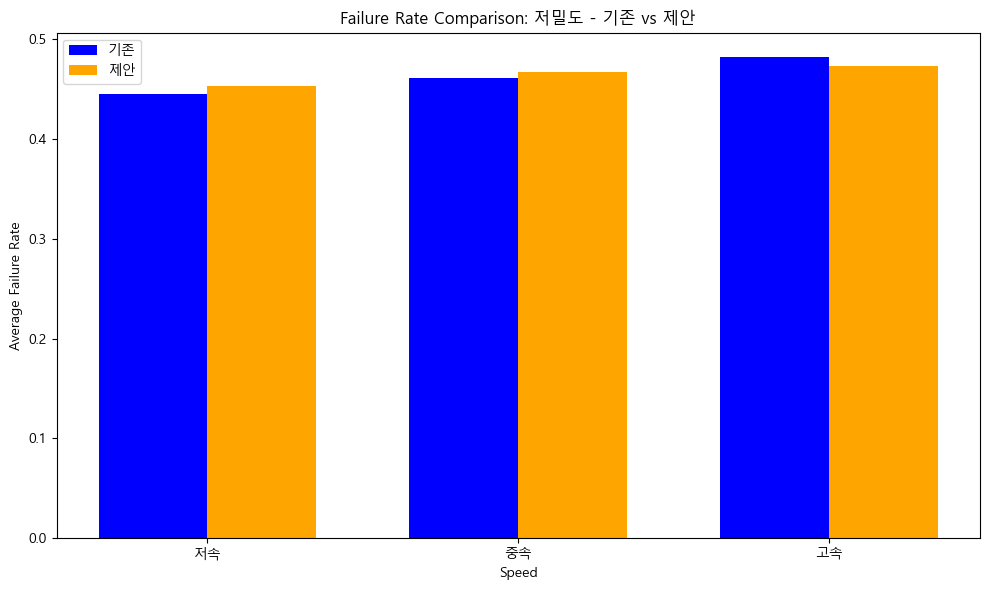

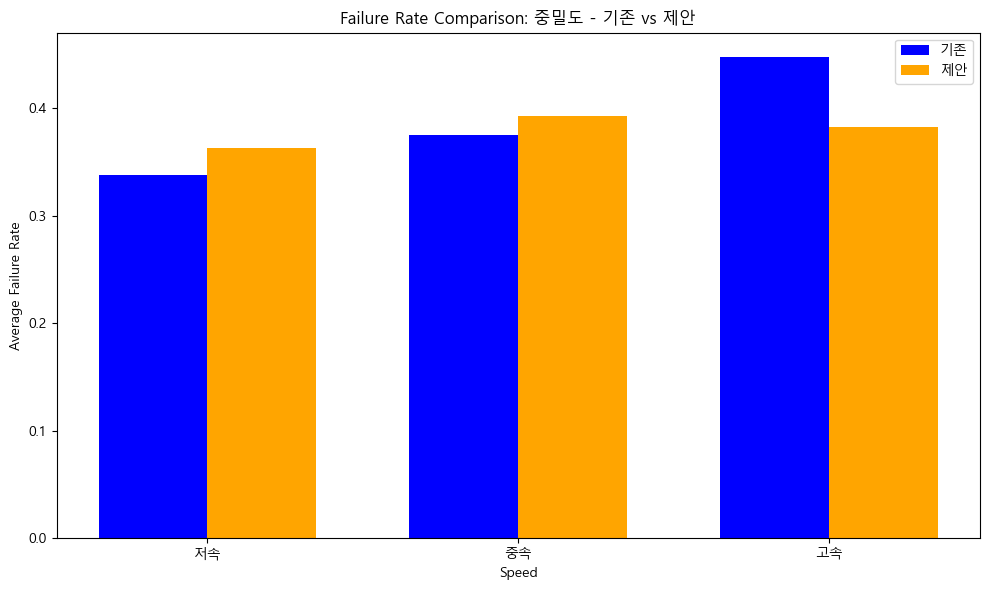

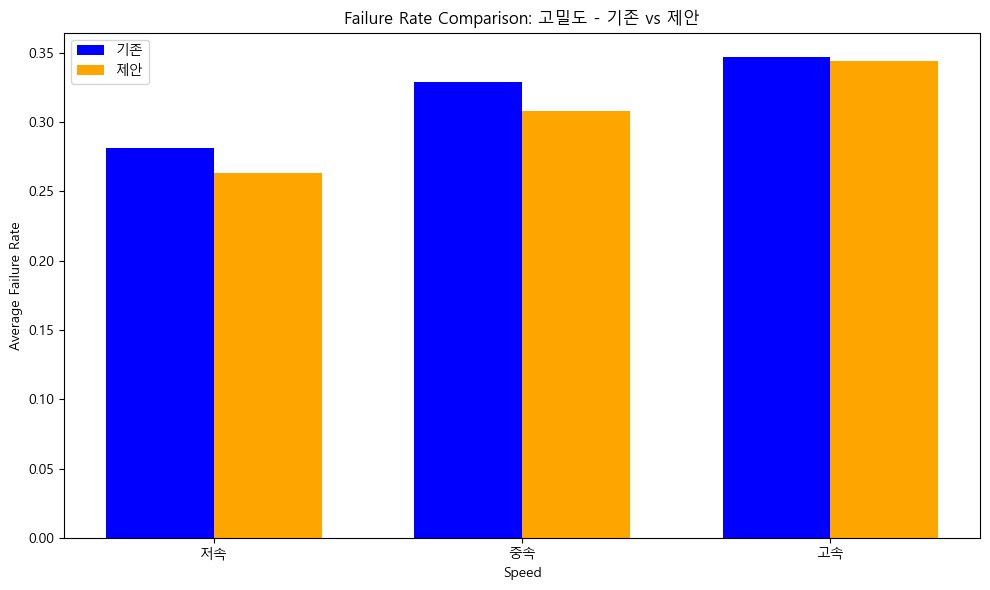

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

file_path = 'failed_node_detail.csv'
data = pd.read_csv(file_path)

data['Speed'] = pd.Categorical(data['Speed'], categories=['저속', '중속', '고속'], ordered=True)

environment_avg = data.groupby(['Mode', 'Density', 'Speed'])['Failure_Rate'].mean().reset_index()

for density in ['저밀도', '중밀도', '고밀도']:
    density_data = environment_avg[environment_avg['Density'] == density]
    density_data = density_data.sort_values('Speed')

    plt.figure(figsize=(10, 6))

    bar_width = 0.35
    positions = range(len(density_data['Speed'].unique()))

    기존_avg = density_data[density_data['Mode'] == '기존']
    제안_avg = density_data[density_data['Mode'] == '제안']

    plt.bar(positions, 기존_avg['Failure_Rate'], width=bar_width, label="기존", color='blue')
    plt.bar([p + bar_width for p in positions], 제안_avg['Failure_Rate'], width=bar_width, label="제안", color='orange')

    xticks = ['저속', '중속', '고속']
    plt.xticks([p + bar_width/2 for p in positions], xticks)

    plt.title(f'Failure Rate Comparison: {density} - 기존 vs 제안')
    plt.xlabel('Speed')
    plt.ylabel('Average Failure Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()
